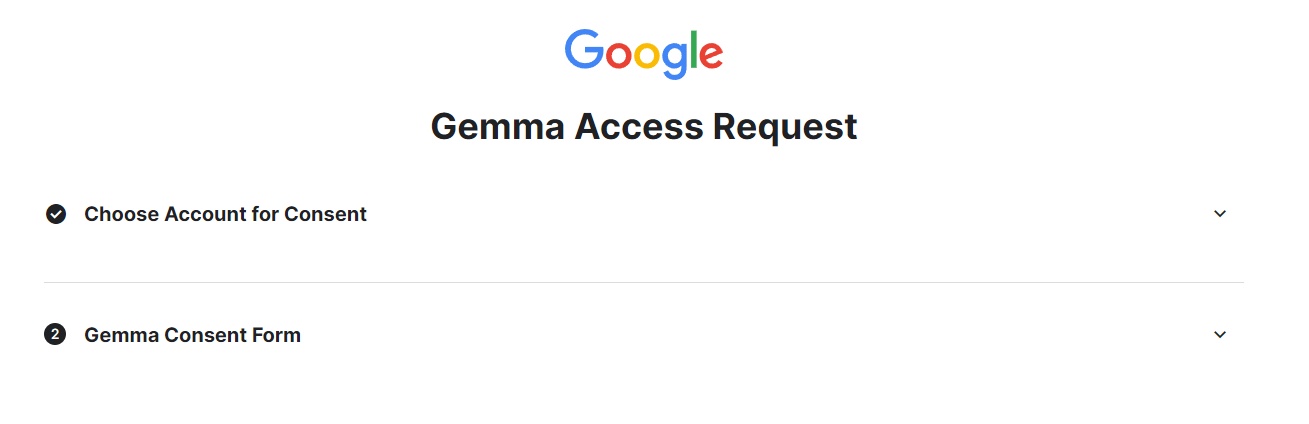

## PaliGemma Fine-tuning

In this notebook, we will fine-tune [pretrained PaliGemma](https://huggingface.co/google/paligemma-3b-pt-448) on a small split of [VQAv2](https://huggingface.co/datasets/HuggingFaceM4/VQAv2) dataset. Let's get started by installing necessary libraries.

In [ ]:
!pip install -q -U git+https://github.com/huggingface/transformers.git datasets accelerate

We will authenticate to access the model using `notebook_login()`.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Let's load the dataset.

In [ ]:
from datasets import load_dataset
ds = load_dataset('HuggingFaceM4/VQAv2', split="train[:10%]")


In [ ]:
cols_remove = ["question_type", "answers", "answer_type", "image_id", "question_id"]
ds = ds.remove_columns(cols_remove)

In [ ]:
split_ds = ds.train_test_split(test_size=0.05) # we'll use a very small split for demo
train_ds = split_ds["test"]

In [ ]:
train_ds

Load the processor to preprocess the dataset.

In [ ]:
from transformers import PaliGemmaProcessor
model_id = "google/paligemma-3b-pt-224"
processor = PaliGemmaProcessor.from_pretrained(model_id)

We will preprocess our examples. We need to prepare a prompt template and pass the text input inside, pass it with batches of images to processor. Then we will set the pad tokens and image tokens to -100 to let the model ignore them. We will pass our preprocessed input as labels to make the model learn how to generate responses.

In [ ]:
import torch
device = "cuda"

image_token = processor.tokenizer.convert_tokens_to_ids("<image>")
def collate_fn(examples):
  texts = ["answer " + example["question"] for example in examples]
  labels= [example['multiple_choice_answer'] for example in examples]
  images = [example["image"].convert("RGB") for example in examples]
  tokens = processor(text=texts, images=images, suffix=labels,
                    return_tensors="pt", padding="longest",
                    tokenize_newline_separately=False)

  tokens = tokens.to(torch.bfloat16).to(device)
  return tokens


Our dataset is a very general one and similar to many datasets that PaliGemma was trained with. In this case, we do not need to fine-tune the image encoder, the multimodal projector but we will only fine-tune the text decoder.

In [ ]:
from transformers import PaliGemmaForConditionalGeneration
import torch

model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)

for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False


Alternatively, if you want to do LoRA and QLoRA fine-tuning, you can run below cells to load the adapter either in full precision or quantized.

In [ ]:
from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_type=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
#trainable params: 11,298,816 || all params: 2,934,634,224 || trainable%: 0.38501616002417344


We will now initialize the `TrainingArguments`.

In [ ]:
from transformers import TrainingArguments
args=TrainingArguments(
            num_train_epochs=2,
            remove_unused_columns=False,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            learning_rate=2e-5,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=100,
            optim="adamw_hf",
            save_strategy="steps",
            save_steps=1000,
            push_to_hub=True,
            save_total_limit=1,
            output_dir="paligemma_vqav2",
            bf16=True,
            report_to=["tensorboard"],
            dataloader_pin_memory=False
        )


We can now start training.

In [ ]:
from transformers import Trainer

trainer = Trainer(
        model=model,
        train_dataset=train_ds ,
        data_collator=collate_fn,
        args=args
        )


In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

You can find steps to infer [here](https://colab.research.google.com/drive/100IQcvMvGm9y--oelbLfI__eHCoz5Ser?usp=sharing).